In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
%matplotlib notebook
import sklearn
import skimage
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split

import os
from skimage.transform import resize
import pylab

import pydicom as pyd

from scipy import ndimage, misc

import cv2

In [2]:
def dcmchange(orig,clahe,equal) :
    r,c = orig.shape
    new = np.empty((r,c,3), dtype=orig.dtype)
#     new[:,:,:] = orig[:,:,np.newaxis]
    new[:,:,0] = orig[:,:]
    new[:,:,1] = clahe[:,:]
    new[:,:,2] = equal[:,:]
    return new

In [3]:
# Feature
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

In [4]:
p = Path("dataset/")
dirs = p.glob("*")
labels_dict = {'CA lung':0, 'Extra':1, 'Heart':2,
               'Abnormal': 3, 'No Finding': 4, 'TB': 5, 'Pneumonia' : 6}
count = 0

ex_images = []
normal_images = []
ex_labels = []
normal_labels = []

count_normal = 0
count_ex = 0

for folder_dir in dirs:
    label = str(folder_dir).split("\\")[-1][:-1]
#     print(label)
#     print(folder_dir)
    if label == 'Extra' or label == 'No Finding' :
        for img_path in folder_dir.glob("*.dcm"):
#             print(img_path)
#             pic = pyd.read_file(os.path.normpath(img_path))
            target = "./" + str(img_path)

            pic = pyd.read_file(target)
            pic_r = np.array(pic.pixel_array)
            %matplotlib inline 
    #         preprocessing
            clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
            pic_r1 = clahe.apply(pic_r)
    #         preprocessing
            IMG_PX_SIZE = 224
            resized_img1 = resize(pic_r, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_clahe = resize(pic_r1, (IMG_PX_SIZE, IMG_PX_SIZE), anti_aliasing=True)
            resized_equal = exposure.equalize_adapthist(resized_img1, clip_limit=0.03)
            #change pic to (224,224,3)
            resized_img2 = dcmchange(resized_img1,resized_clahe,resized_equal)
            resized_img = exposure.equalize_adapthist(resized_img2, clip_limit=0.03)
    #         resized_img = resized_img.flatten()

            if label == 'Extra' :
                ex_images.append(resized_img)
                ex_labels.append(labels_dict[label])
    #             heart_images.append(ndimage.rotate(resized_img2, 1, reshape=False))
                count_ex+=1
            elif label == 'No Finding' :
                normal_images.append(resized_img)
                normal_labels.append(labels_dict[label])
                count_normal+=1

            if count_normal == 200 or count_ex == 200 : 
                break

        count_normal = 0
        count_ex = 0


In [5]:
normal_labels = np.array(normal_labels)
normal_images = np.array(normal_images, dtype=np.float32)
ex_labels = np.array(ex_labels)
ex_images = np.array(ex_images, dtype=np.float32)

In [6]:
print("number of sample No Finding: {}".format(len(normal_images)))
print("number of sample Extra: {}".format(len(ex_images)))

number of sample No Finding: 200
number of sample Extra: 200


In [7]:
normal_images.shape[0]

200

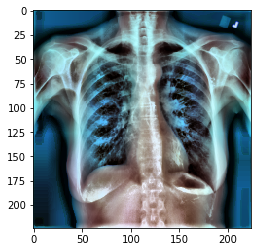

In [8]:
plt.imshow(normal_images[3])

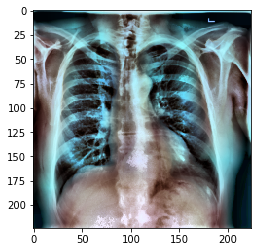

In [9]:
plt.imshow(ex_images[3])

## Feature

In [10]:
from sklearn.preprocessing import StandardScaler
def scaling(X_train,X_test,X_val) :
    #Feature Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.fit_transform(X_test)
    X_val = sc.fit_transform(X_val)
    return X_train,X_test,X_val

In [11]:
from sklearn.metrics import accuracy_score
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc


## Model

In [12]:
from sklearn.neighbors import KNeighborsClassifier
def knn_model(X_train_recv,y_train_recv,X_test_recv,y_test_recv,X_val_recv,y_val_recv,r) :
    knn = KNeighborsClassifier(n_neighbors = 1)
    #train Model 
    knn.fit(X_train_recv,y_train_recv)
    score = knn.score(X_test_recv, y_test_recv)
    print("Score : {}".format(score))
    
    y_score = knn.predict_proba(X_val_recv)[:, 1]
#     y_check = model_svm.predict(X_val)
#     print(y_check)
    y_pred = knn.predict(X_val_recv)
#     print(y_pred)
    accuracy = accuracy_score(y_val_recv,y_pred)
#     for x in zip(y_score2,y_pred) :
#         print(x)
    
    print("KNN accuracy from Fold {} : {}".format(r,accuracy))
    #Confusion Matrix
    %matplotlib inline 
    confusion(y_val_recv,y_pred)
    
    #roc
    fpr, tpr, thresholds = roc_curve(y_val_recv, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    
    return fpr,tpr,roc_auc

## Confusion 

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def confusion(y_test,pred) :
    #Confusion Matrix
    %matplotlib inline 

    confusion_mat1 = confusion_matrix(y_test, pred)
    confusion_mat1 = confusion_mat1.astype('float') / confusion_mat1.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(confusion_mat1, annot=True, fmt=".2f")

    plt.show()

## ROC

In [14]:
def roc(fpr_recv,tpr_recv,acc_recv) :
#     stck_auc = []
    color = ["orange","green","blue","red","purple"]
    for i in range(5):
        fpr_use = fpr_recv[i]
        tpr_use = tpr_recv[i]
        acc_use = acc_recv[i]
#         auc = roc_auc_score(y_val_rec, roc_pred)
#         print('AUC Fold %d: %0.4f' %(i,auc))
        
        plt.plot(fpr_use, tpr_use, color='{}'.format(color[i]), label='AUC Fold %d: %0.4f' %(i,acc_use))
        plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend()
    plt.show()

In [15]:
# import scipy.ndimage
from scipy import ndimage
# def incre(data,labels):
#     new_data = []
#     new_label = []
#     for i in range(data.shape[0]):
#         new_data.append(data[i])
#         flip = cv2.flip(data[i],1)
#         new_data.append(cv2.flip(flip[i],1))
#         new_data.append(ndimage.rotage(flip[i],5,reshape=False))
#         new_data.append(ndimage.rotage(data[i],5,reshape=False))
#         new_data.append(ndimage.rotage(data[i],-5,reshape=False))
#         new_label.append(labels[i])
#         new_label.append(labels[i])
#         new_label.append(labels[i])
#         new_label.append(labels[i])
#         new_label.append(labels[i])
#     new_data = np.array(new_data)
#     new_label = np.array(new_label)
#     return new_data,new_label
def incre(data,labels):
    new_data = []
    new_label = []
    for i in range(data.shape[0]):
        new_data.append(data[i].flatten())
        flip = cv2.flip(data[i],1)
        new_data.append(flip.flatten())
        new_data.append((ndimage.rotate(data[i], 5, reshape=False)).flatten())
        new_data.append((ndimage.rotate(data[i], -5, reshape=False)).flatten())
#         new_data.append((ndimage.rotate(flip,5,reshape=False)).flatten())
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
        new_label.append(labels[i])
#         new_label.append(labels[i])
    new_data = np.array(new_data)
    new_label = np.array(new_label)
    return new_data,new_label

## RUN

In [16]:
from sklearn.svm import SVC
import nltk
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import random
def AllinOne2(other, normal) :
    data = []
    label = []
    box_tpr = []
    box_fpr = []
    box_acc = []
    index = 0
    for i in range(5):
        for count in range(int(normal.shape[0]/5)):
            data.append(normal[index+count])
            label.append(1)
#             print(index+count)
        for count in range(int(other.shape[0]/5)):
            data.append(other[index+count])
            label.append(0)
        index+=int(normal.shape[0]/5)  
    data = np.array(data)
    label = np.array(label)
    train_data, X_test, label_train, y_test = train_test_split(data, label, test_size=0.2)
    X_test_s,y_test_n = incre(X_test,y_test)
    k=0       
    kf = KFold(5, shuffle=True)
    for train, val in kf.split(train_data):
        X_train = train_data[train]
        X_val = train_data[val]
        y_train = label_train[train]
        y_val = label_train[val]
        X_train_s,y_train_n = incre(X_train,y_train)
        X_val_s,y_val_n = incre(X_val,y_val)
#         print(y_val)
        # Feature      
        X_train_n,X_test_n,X_val_n = scaling(X_train_s,X_test_s,X_val_s)
     # run model
        recv_fpr,recv_tpr,recv_acc = knn_model(X_train_n,y_train_n,X_test_n,y_test_n,X_val_n,y_val_n,k)
        box_fpr.append(recv_fpr)
        box_tpr.append(recv_tpr)
        box_acc.append(recv_acc)
        k+=1
        #f1-score
#         cm_plot_labels = ['Finding', 'Normal']
#         print(classification_report(y_val, probs, target_names=cm_plot_labels))
    # ROC
    roc(box_fpr,box_tpr,box_acc)

Score : 0.753125
KNN accuracy from Fold 0 : 0.85546875


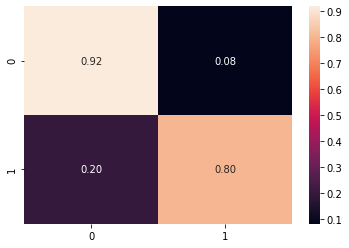

Score : 0.778125
KNN accuracy from Fold 1 : 0.76171875


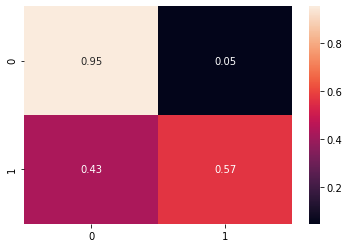

Score : 0.734375
KNN accuracy from Fold 2 : 0.7734375


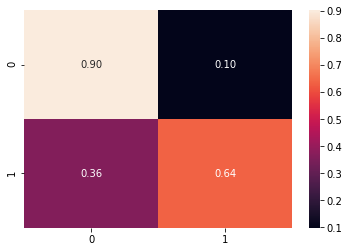

Score : 0.709375
KNN accuracy from Fold 3 : 0.8125


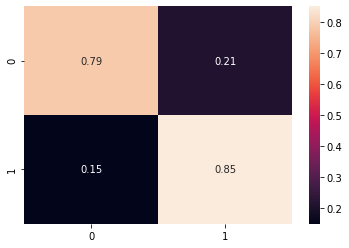

Score : 0.815625
KNN accuracy from Fold 4 : 0.86328125


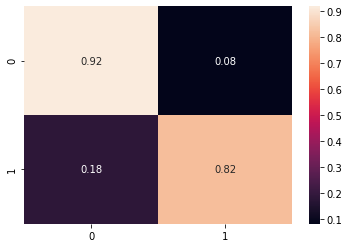

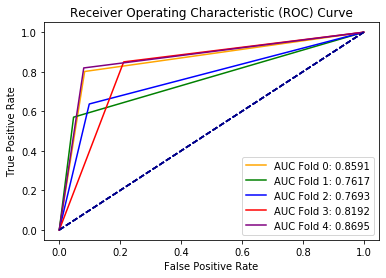

In [17]:
AllinOne2(ex_images, normal_images)